In [1]:
import sys
sys.path.append('/home/linxy29/.conda/envs/vivian_data/lib/python3.10/site-packages')
sys.path

['/home/linxy29/Code/Ho_vivian_python',
 '/home/linxy29/.conda/envs/vivian_data/lib/python310.zip',
 '/home/linxy29/.conda/envs/vivian_data/lib/python3.10',
 '/home/linxy29/.conda/envs/vivian_data/lib/python3.10/lib-dynload',
 '',
 '/home/linxy29/.conda/envs/vivian_data/lib/python3.10/site-packages',
 '/home/linxy29/.local/lib/python3.10/site-packages',
 '/home/linxy29/.conda/envs/vivian_data/lib/python3.10/site-packages']

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/linxy29/.conda/envs/vivian_data/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [4]:
results_file = '/storage/holab/linxy/vivian/scanpy/ncc_scanpy.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_mtx(
    '/storage/holab/linxy/vivian/ncc_cellranger/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/storage-holab-linxy-vivian-ncc_cellranger-outs-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 2631 × 36601
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


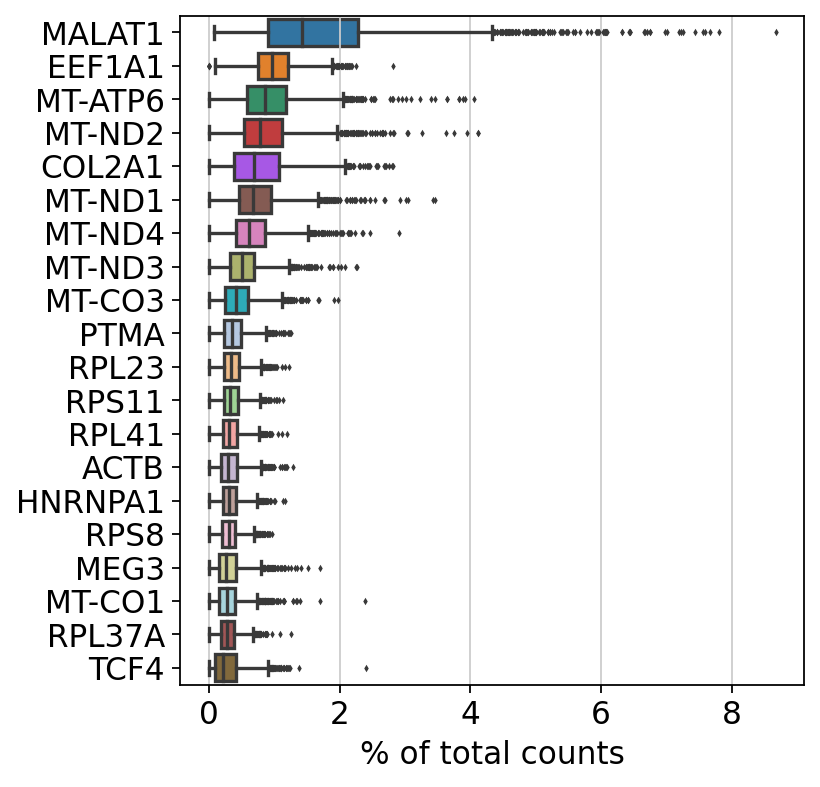

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19797 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

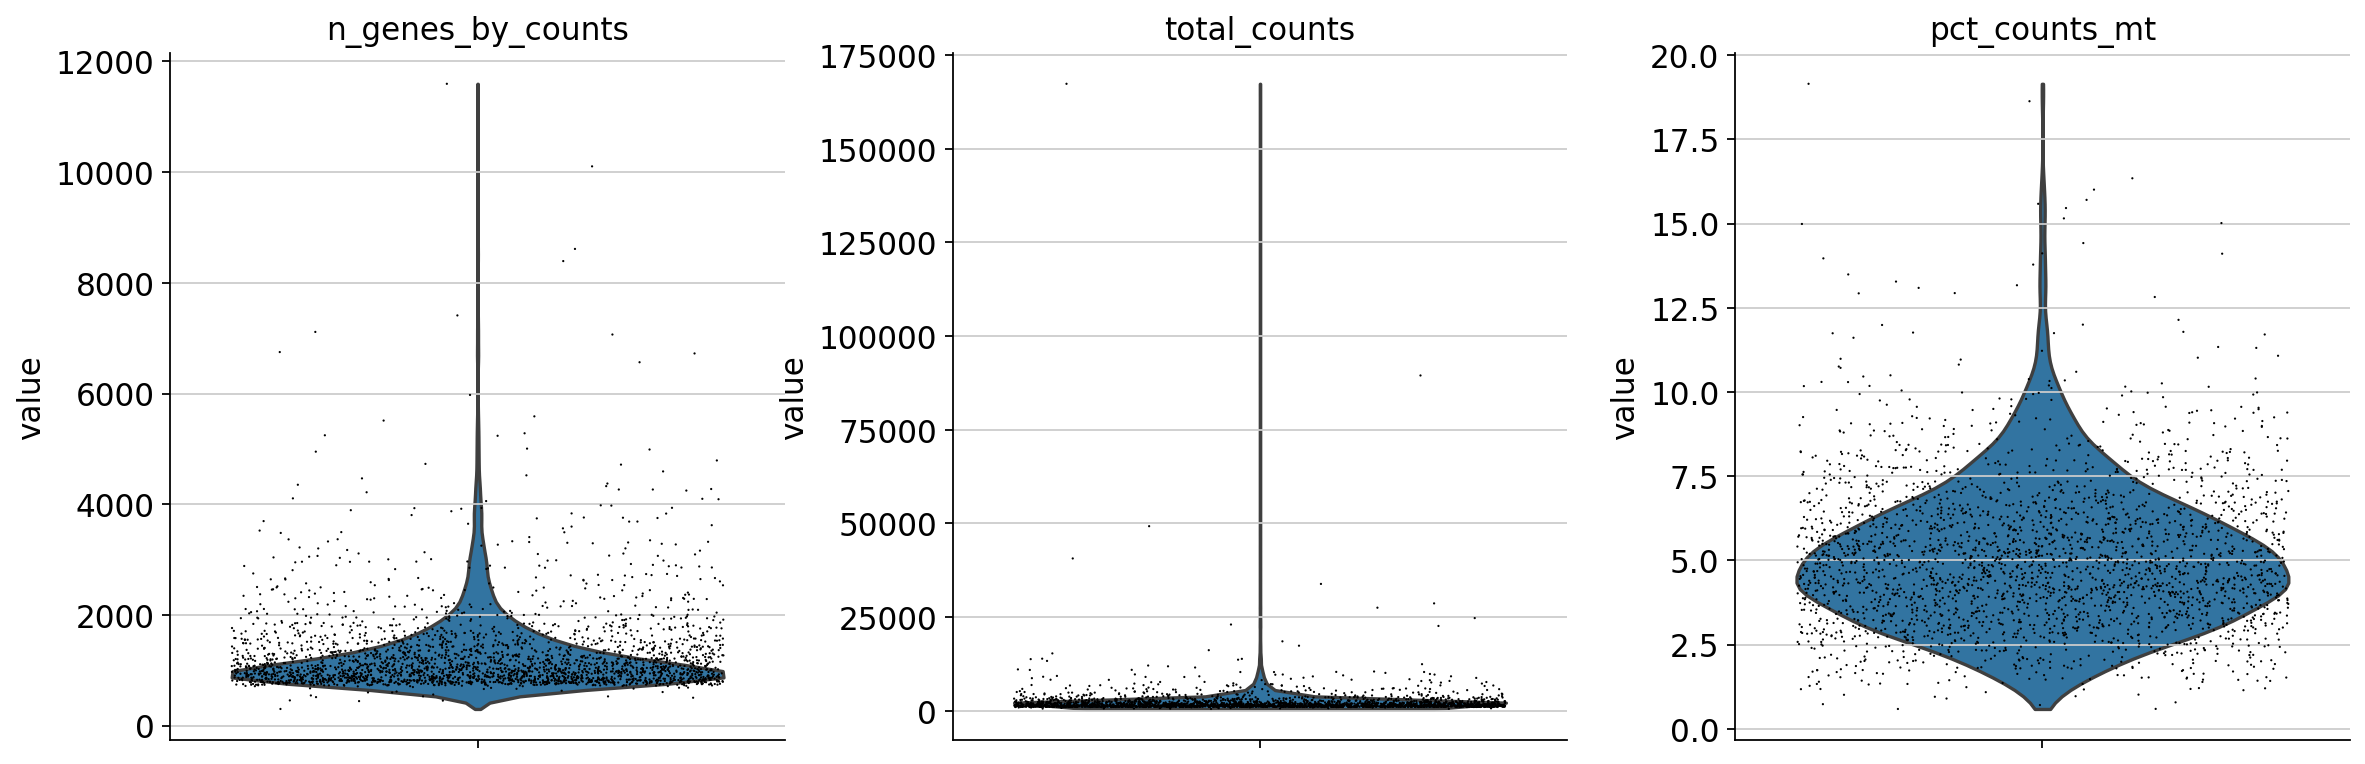

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

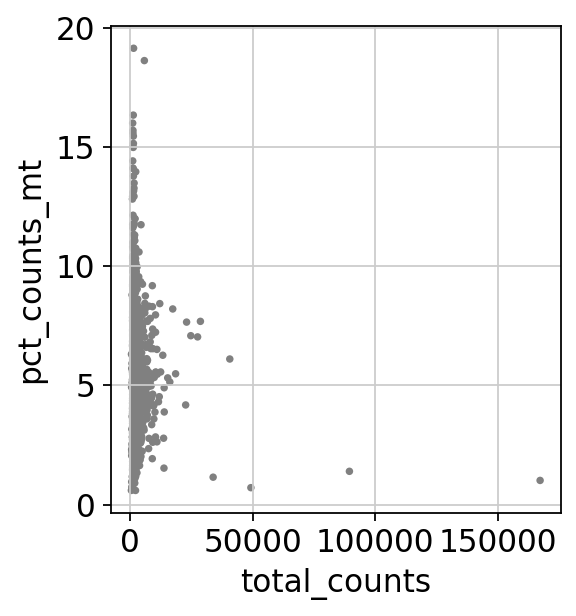

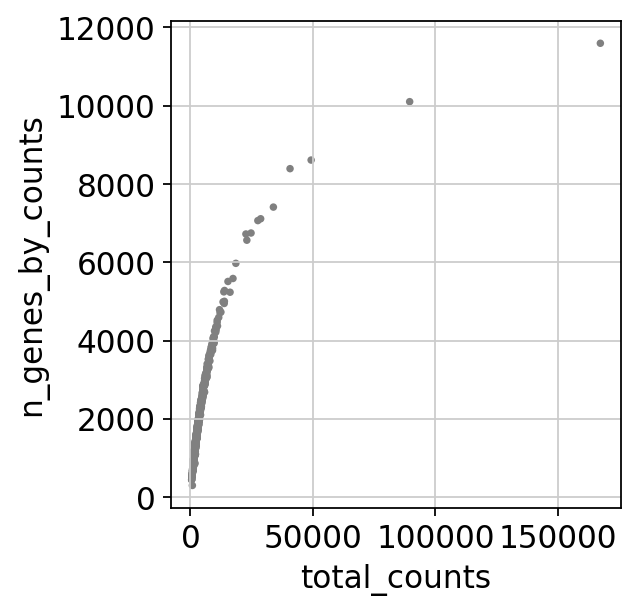

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

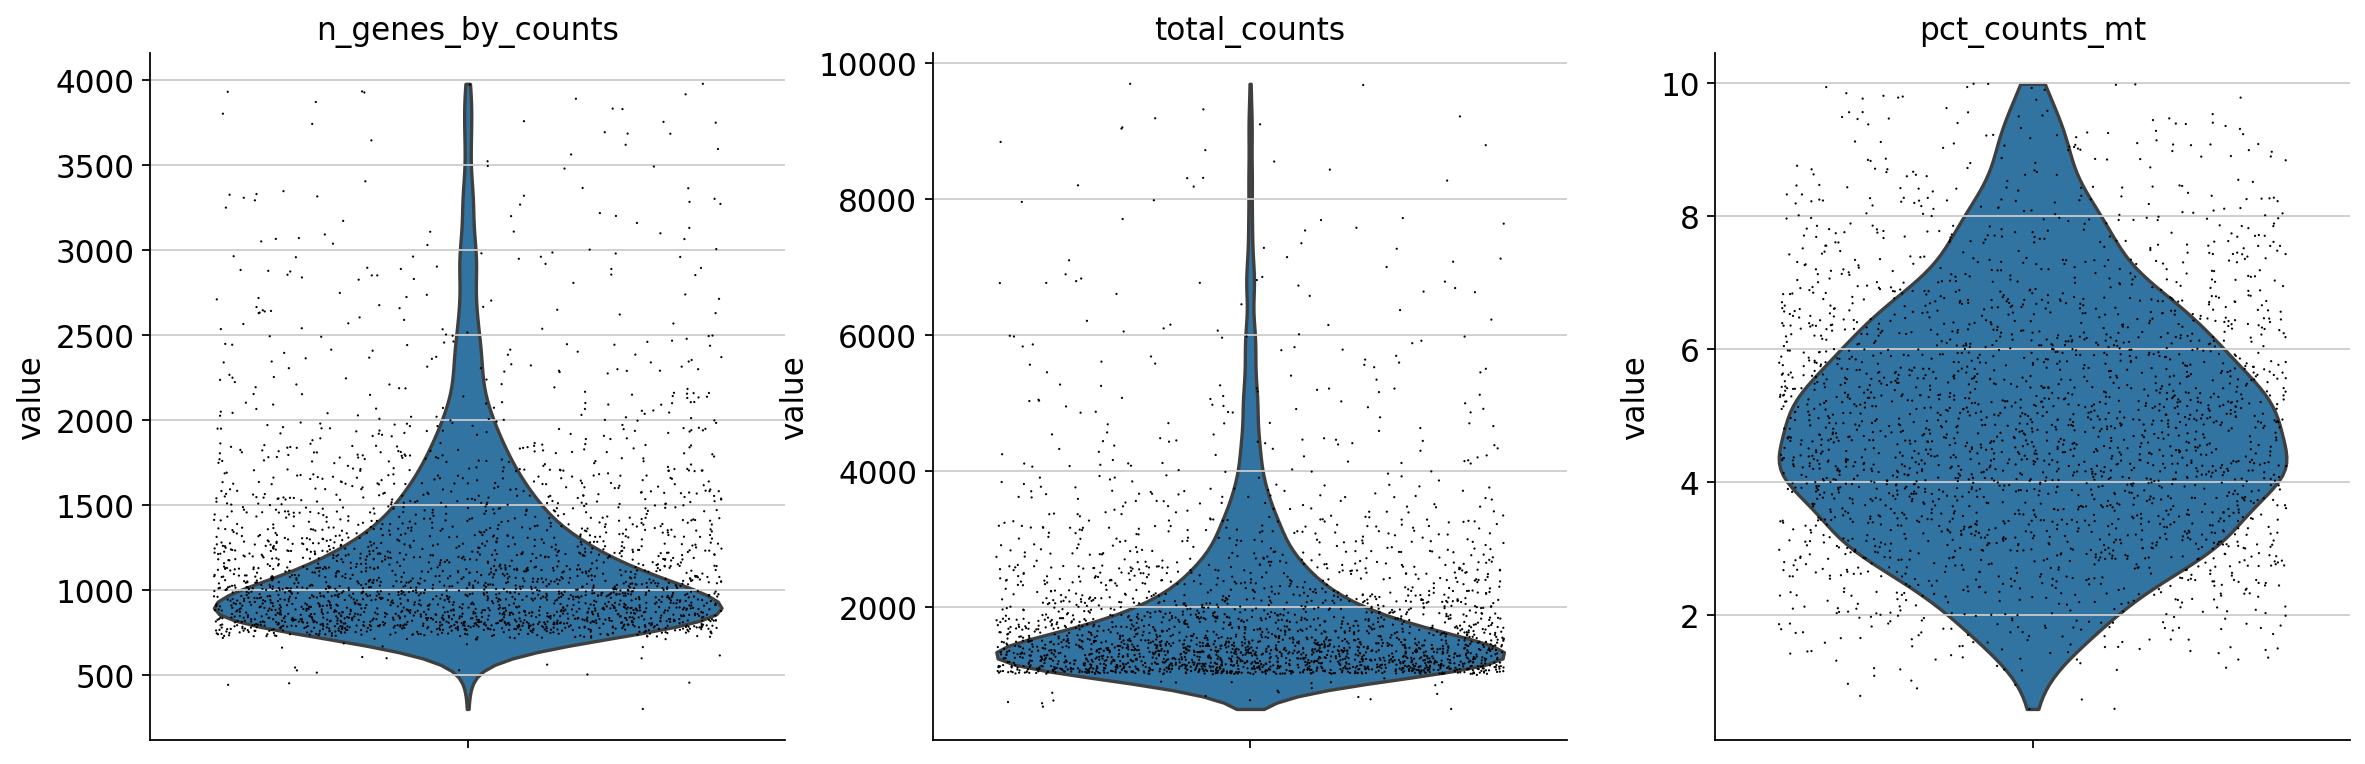

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

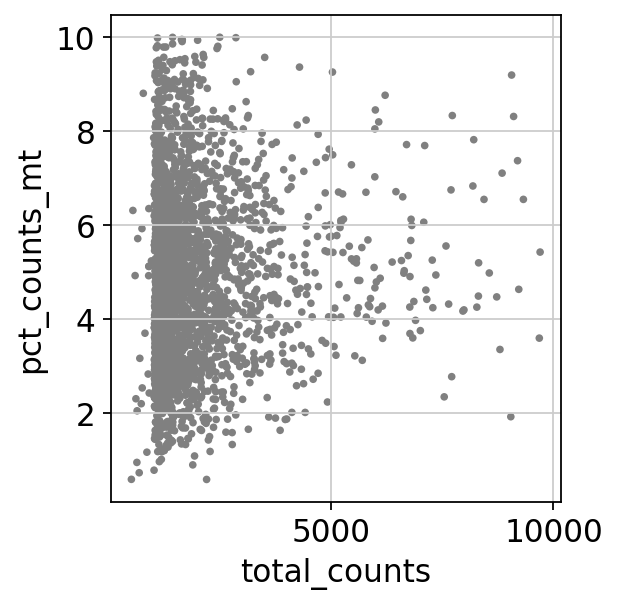

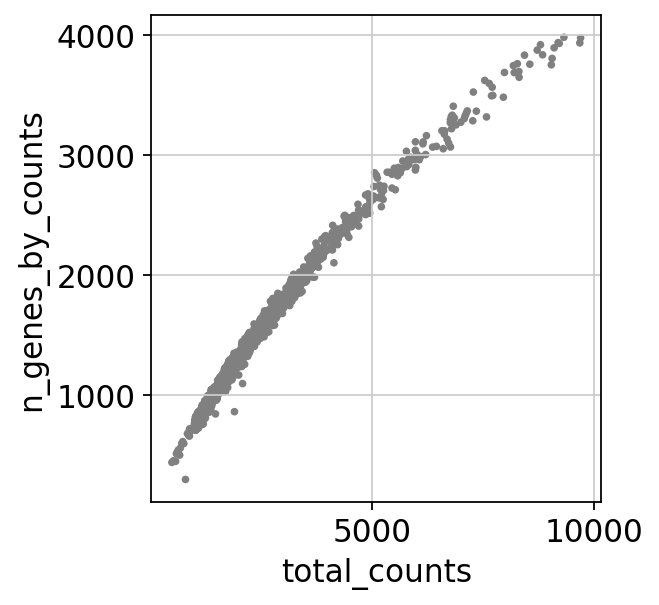

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/linxy29/.conda/envs/vivian_data/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [19]:
adata.raw = adata

In [20]:
adata = adata[:, adata.var.highly_variable]

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


In [22]:
sc.pp.scale(adata, max_value=10)

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [24]:
adata.write(results_file)

In [25]:
adata

AnnData object with n_obs × n_vars = 2535 × 2252
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [27]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


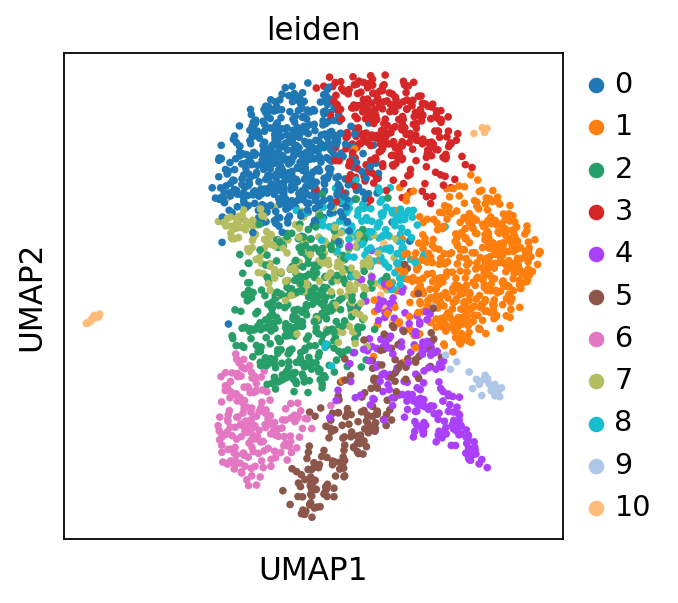

In [28]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [29]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


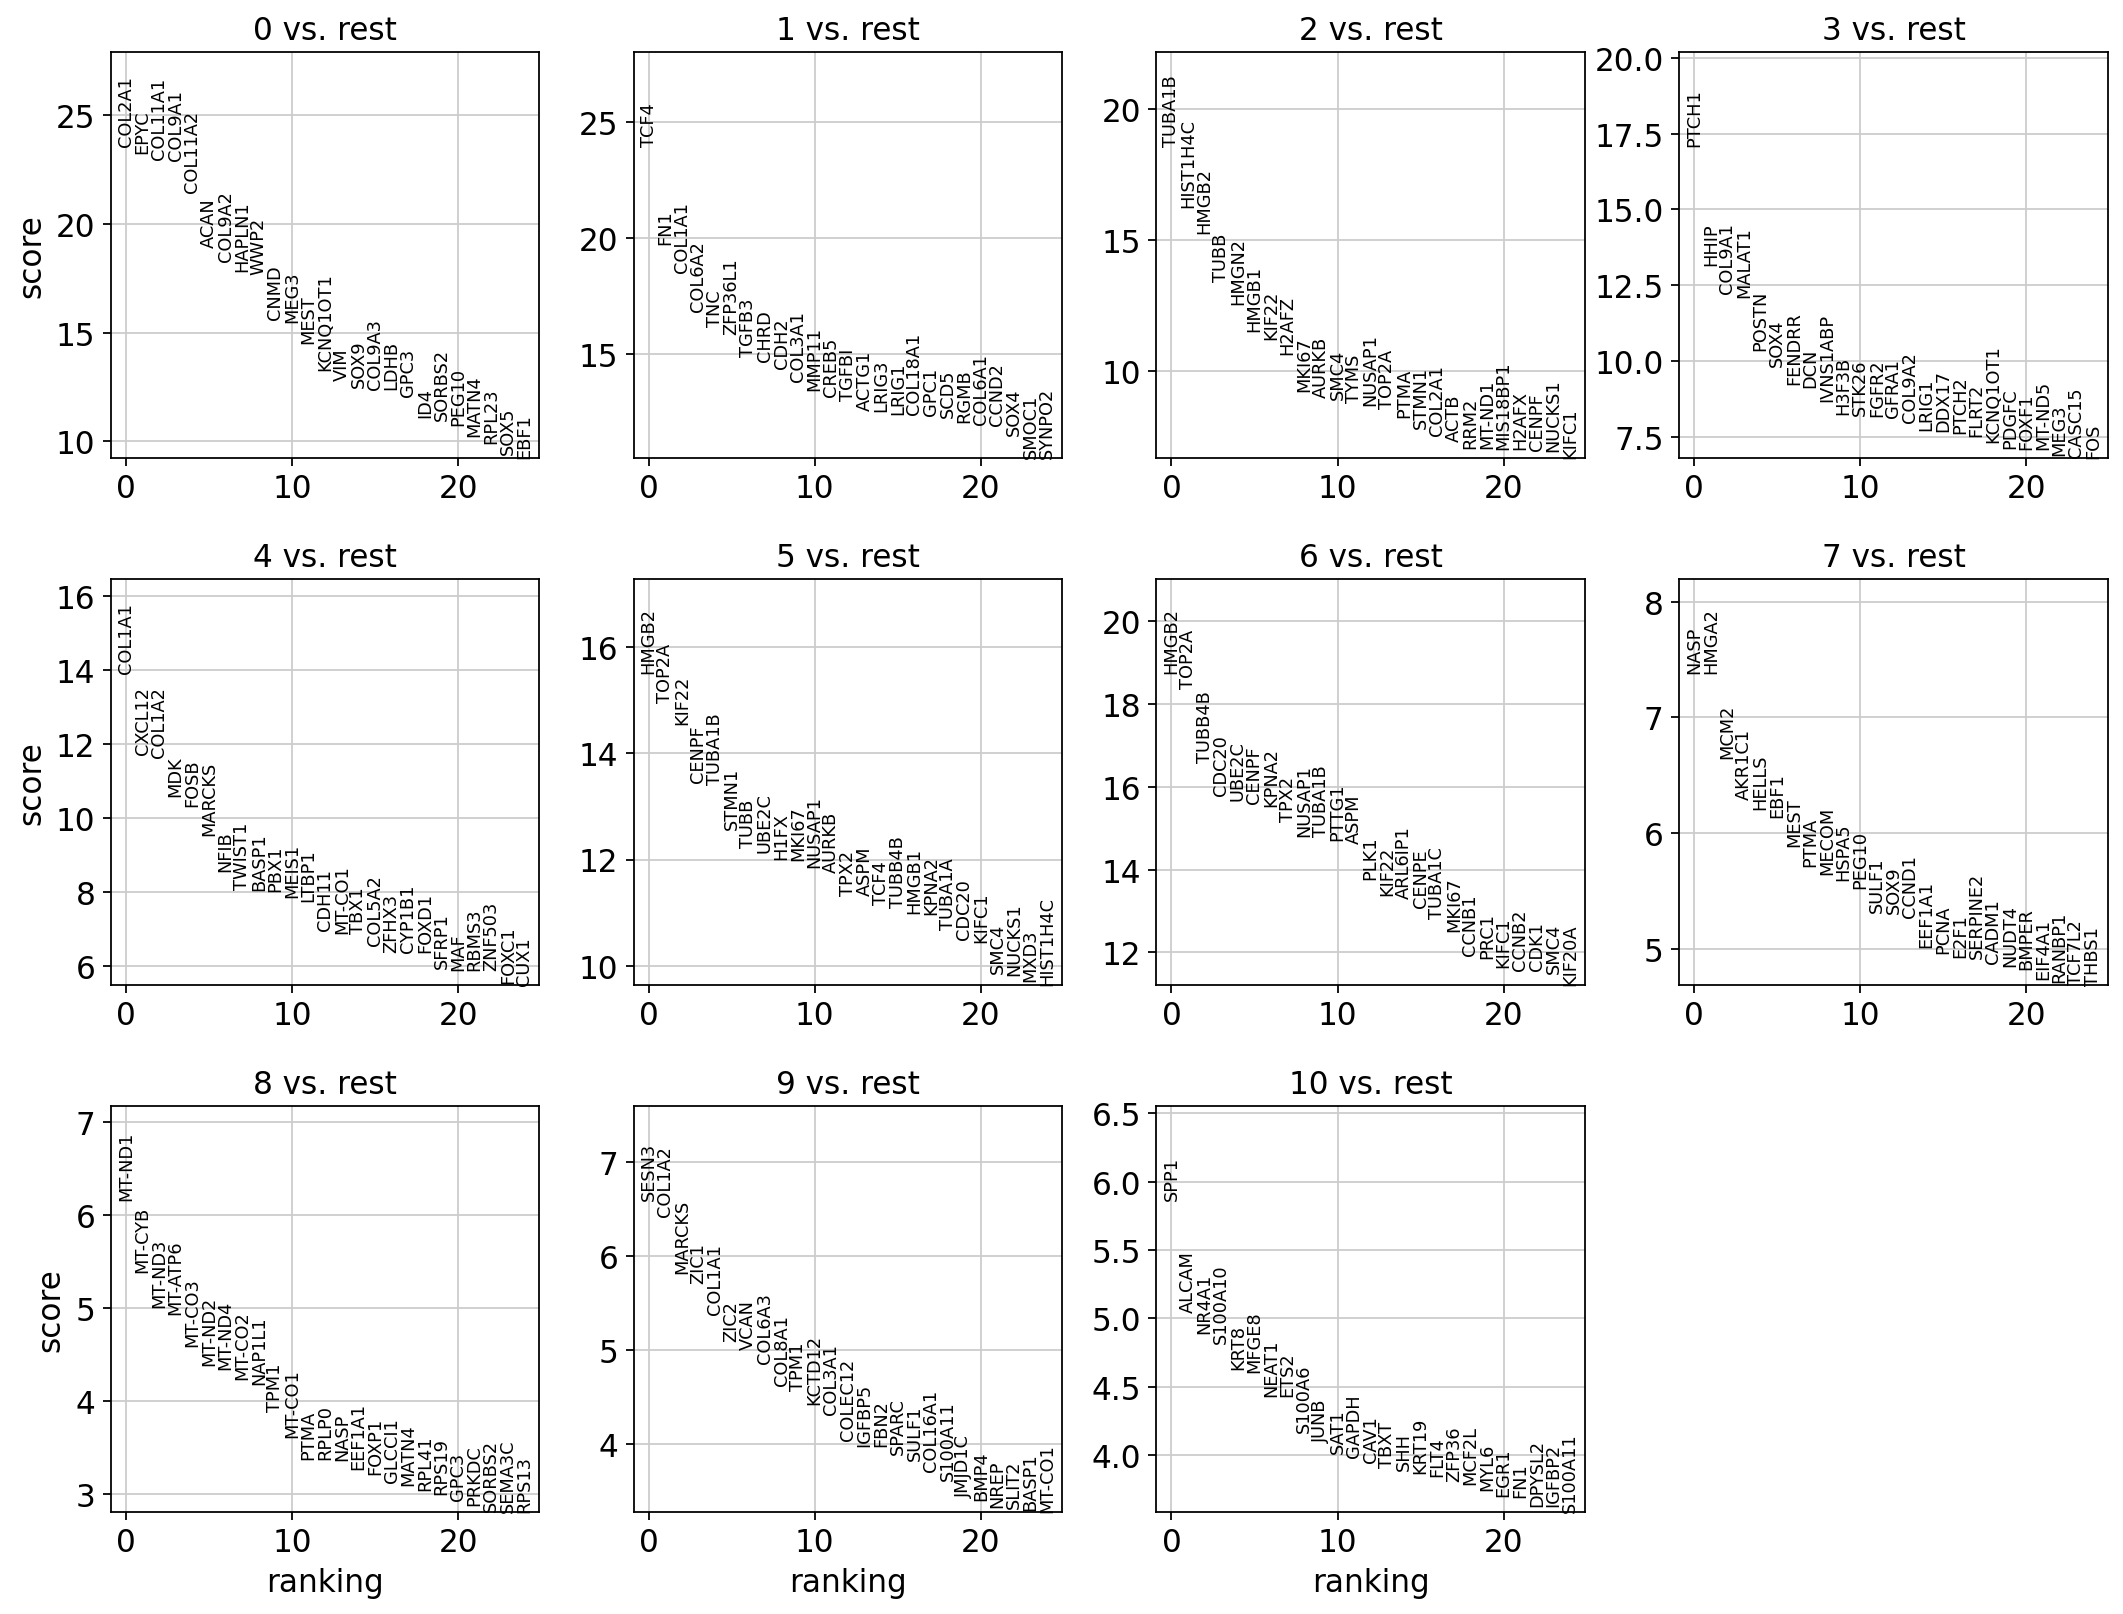

In [30]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2535 × 2252
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,COL2A1,TCF4,TUBA1B,PTCH1,COL1A1,HMGB2,HMGB2,NASP,MT-ND1,SESN3,SPP1
1,EPYC,FN1,HIST1H4C,HHIP,CXCL12,TOP2A,TOP2A,HMGA2,MT-CYB,COL1A2,ALCAM
2,COL11A1,COL1A1,HMGB2,COL9A1,COL1A2,KIF22,TUBB4B,MCM2,MT-ND3,MARCKS,NR4A1
3,COL9A1,COL6A2,TUBB,MALAT1,MDK,CENPF,CDC20,AKR1C1,MT-ATP6,ZIC1,S100A10
4,COL11A2,TNC,HMGN2,POSTN,FOSB,TUBA1B,UBE2C,HELLS,MT-CO3,COL1A1,KRT8


In [34]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).to_csv('/storage/holab/linxy/vivian/scanpy/ncc_scanpy_markers.csv')